# Part 3

## 1) Cleaning Data and Analysis

### Cleaning Data

Both the average rating of drivers and the average rate by drivers contained null values. The nulls were assigned the median for that feature. Cities, as a categorical column, was separated into 2 dummy boolean columns (King's Landing and Winterfell).  Phone type, which was also categorical, was converted into 2 boolean dummy variables (iPhone or Android) with those nulls disappearing.

### Visualization

74% of drivers were retained. User data were separated, for the purposes of visualization, by whether they were active. The distribution of numerical features was viewed as a histagram and categorical or boolean features were viewed as bar plots. 

## 2) Predictive Model

Choosing a simple model is usually preferable (when the simplistic model is accurate enough) because they are easier to interpret. The simplistic method of logistical regression was chosen first. The accuracy of this model was 74%, even after hyperparameterization, which was much lower than was desired. The gradient boosting model, which is well known to product accurate results and will give feature importance, was then chosen. The MinMaxScaler class of sklearn was used to normalize the data while leaving booleans as 1’s and 0’s (though their type was changed to a float). I hyperparameterized the gradient boosting method with a random search rather than a grid search in order to sample a large number of parameters in a reasonable amount of time. The accuracy of final model was 93%, a very good fit.

## 3) Discuss 

Since the final model was a very good fit and accurate on the test data, I am confident that the model captured the behavior of the drivers. The most important features are average distance in the first 30 days, the number of trips in the first 30 days, and  percentage of users who took weekend trips. Based on the data means and histagrams below, active drivers have lower average trip distances but greater number of trips and higher percentage of weekend trips. The recommend, based on this data, is that new drivers should be encouraged to take more but closer trips in order to be retained. They also should be encouraged to take trips on the weekends. 

In [2]:
import json
import numpy as np
import pandas as pd

#import time
import datetime as dt
from datetime import datetime, timedelta,time

#visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.lines as mlines

#machine learning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,normalize,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.exceptions import DataConversionWarning
import xgboost as xgb

#ignore known warnings
import warnings
warnings.simplefilter(action='ignore', category= DataConversionWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Formatting data for Visualization, not wrangling

In [ ]:
#open file
filename = 'ultimate_data_challenge.json'
with open(filename) as f:
    riders = json.load(f)
riders_df = pd.DataFrame(riders)

#convert signup_date string to datetime 
riders_df['signup_date'] = pd.to_datetime(riders_df['signup_date']) 
riders_df['last_trip_date'] = pd.to_datetime(riders_df['last_trip_date']) 

riders_df['phone'] = riders_df['phone'].fillna('Unknown')

#final the column to predict, active user. Active users took a trip 30 days or more after signing up.
riders_df['length active'] = riders_df[['signup_date','last_trip_date']].apply(lambda x:(x[1]-x[0]),axis=1)

riders_df['active'] = riders_df[['signup_date','last_trip_date']].apply(lambda x: 'Active' if(x[1]-x[0]) >= timedelta(days=30) else 'Not Active',axis=1)

# Average values

In [389]:
riders_df.groupby('active').mean()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
active,,,,,,,,
Active,5.502601,4.769865,4.594341,1.072523,8.779797,2.417814,0.407821,61.345460
Not Active,6.645580,4.802200,4.625679,1.081227,9.050711,1.875456,0.288400,59.716308


# DataFrames For Active Vs Not Active Users

In [387]:
active_df = riders_df[riders_df['active']=='Active']
nonactive_df = riders_df[riders_df['active']=='Not Active']

print('{:.2f}% of drivers are inactive.'.format(
    active_df['avg_dist'].count()/(riders_df['avg_dist'].count())*100))

74.26% of drivers are inactive.


# Visualization 

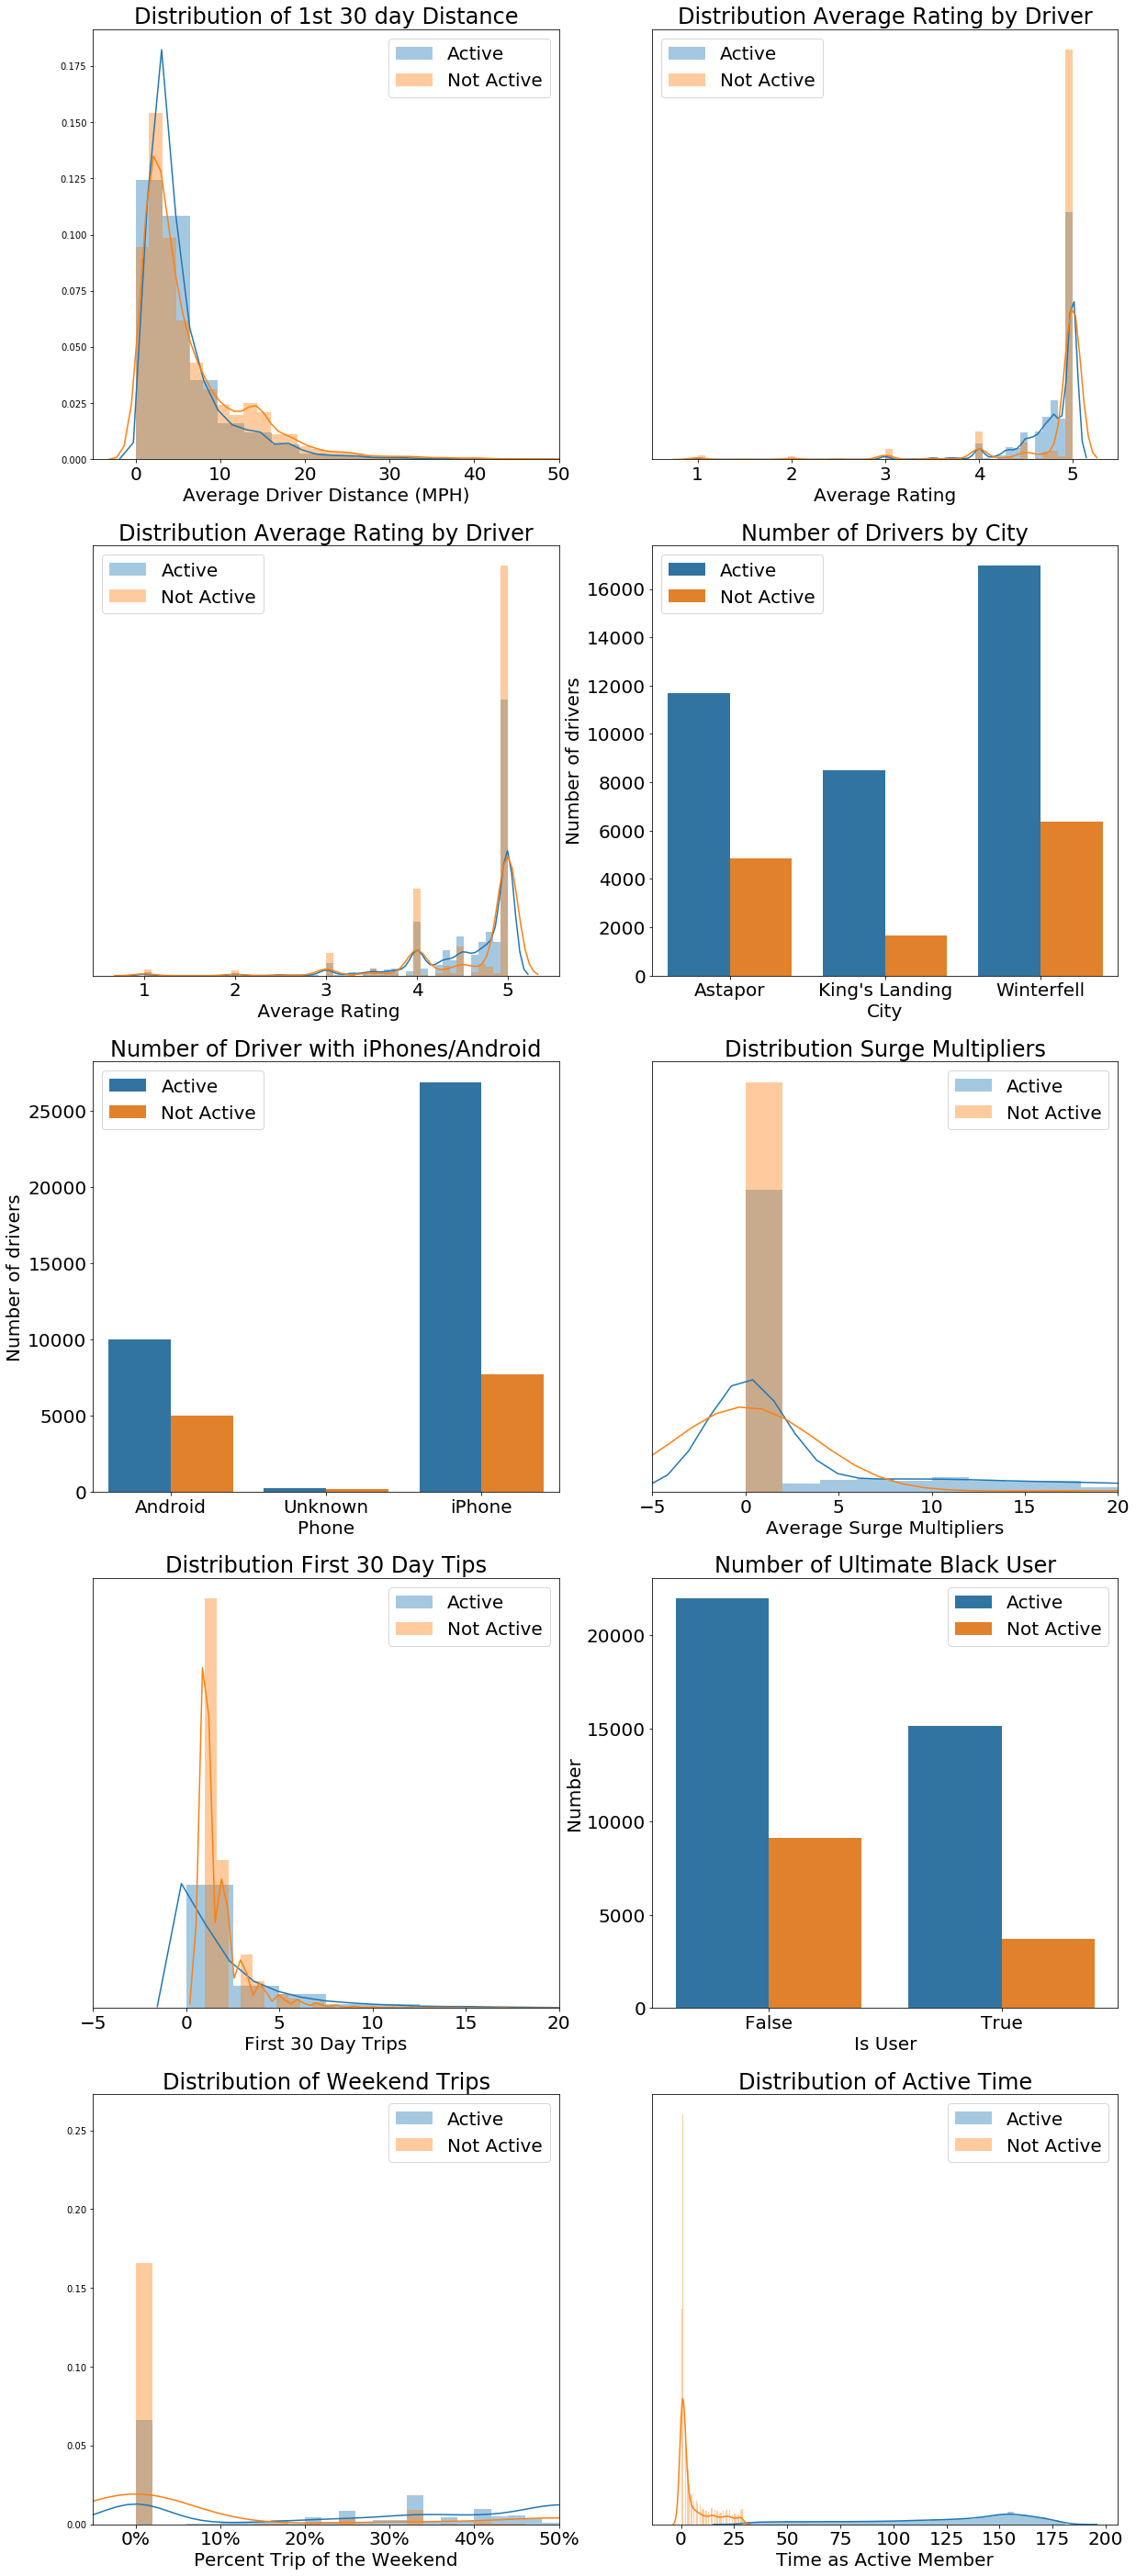

In [365]:
fig = plt.figure(figsize=(20,50)) 


ax1 = fig.add_subplot(5,2,1)
sns.distplot(active_df['avg_dist'],ax=ax1,bins=50,label='Active')
sns.distplot(nonactive_df['avg_dist'],ax=ax1,bins=50,label='Not Active')
plt.xlim([-5,50])
plt.xticks(fontsize=20)
ax1.set_title('Distribution of 1st 30 day Distance',fontsize=24)
ax1.set_xlabel('Average Driver Distance (MPH)',fontsize=20)
plt.legend(fontsize=20)


ax2 = fig.add_subplot(5,2,2)
sns.distplot(active_df[active_df['avg_rating_by_driver'].notnull()]['avg_rating_by_driver']
             ,ax=ax2,bins=50,label='Active')
sns.distplot(nonactive_df[nonactive_df['avg_rating_by_driver'].notnull()]['avg_rating_by_driver']
             ,ax=ax2,bins=50,label='Not Active')
plt.yticks([])
plt.xticks(fontsize=20)
ax2.set_title('Distribution Average Rating by Driver',fontsize=24)
ax2.set_xlabel('Average Rating',fontsize=20)
plt.legend(fontsize=20)

ax3 = fig.add_subplot(5,2,3)
sns.distplot(active_df[active_df['avg_rating_of_driver'].notnull()]['avg_rating_of_driver']
             ,ax=ax3,bins=50,label='Active')
sns.distplot(nonactive_df[nonactive_df['avg_rating_of_driver'].notnull()]['avg_rating_of_driver']
             ,ax=ax3,bins=50,label='Not Active')
plt.yticks([])
plt.xticks(fontsize=20)
ax3.set_title('Distribution Average Rating by Driver',fontsize=24)
ax3.set_xlabel(' Average Rating',fontsize=20)
plt.legend(fontsize=20)

ax4 = fig.add_subplot(5,2,4)
sns.barplot(x='city',
             y='avg_dist',
             hue='active',
             data=riders_df.groupby(['city','active']).count().reset_index(),
             ax=ax4)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
ax4.set_title('Number of Drivers by City',fontsize=24)
ax4.set_xlabel('City',fontsize=20)
ax4.set_ylabel('Number of drivers',fontsize=20)
plt.legend(fontsize=20)

ax5 = fig.add_subplot(5,2,5)
sns.barplot(x='phone',
             y='avg_dist',
             hue='active',
             data=riders_df.groupby(['phone','active']).count().reset_index(),
             ax=ax5)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
ax5.set_title('Number of Driver with iPhones/Android',fontsize=24)
ax5.set_xlabel('Phone',fontsize=20)
ax5.set_ylabel('Number of drivers',fontsize=20)
plt.legend(fontsize=20)

ax6 = fig.add_subplot(5,2,6)
sns.distplot(active_df['surge_pct'],ax=ax6,bins=50,label='Active')
sns.distplot(nonactive_df['surge_pct'],ax=ax6,bins=50,label='Not Active')
plt.xlim([-5,20])
plt.yticks([])
plt.xticks(fontsize=20)
ax6.set_title('Distribution Surge Multipliers',fontsize=24)
ax6.set_xlabel('Average Surge Multipliers',fontsize=20)
plt.legend(fontsize=20)

ax7 = fig.add_subplot(5,2,7)
sns.distplot(active_df['trips_in_first_30_days'],ax=ax7,bins=50,label='Active')
sns.distplot(nonactive_df['trips_in_first_30_days'],ax=ax7,bins=50,label='Not Active')
plt.xlim([-5,20])
plt.yticks([])
plt.xticks(fontsize=20)
ax7.set_title('Distribution First 30 Day Tips',fontsize=24)
ax7.set_xlabel('First 30 Day Trips',fontsize=20)
plt.legend(fontsize=20)


ax8 = fig.add_subplot(5,2,8)
sns.barplot(x='ultimate_black_user',
             y='avg_dist',
             hue='active',
             data=riders_df.groupby(['ultimate_black_user','active']).count().reset_index(),
             ax=ax8)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
ax8.set_title('Number of Ultimate Black User',fontsize=24)
ax8.set_xlabel('Is User',fontsize=20)
ax8.set_ylabel('Number',fontsize=20)
plt.legend(fontsize=20)

ax9 = fig.add_subplot(5,2,9)
sns.distplot(active_df['weekday_pct'],ax=ax9,bins=50,label='Active')
sns.distplot(nonactive_df['weekday_pct'],ax=ax9,bins=50,label='Not Active')
plt.xlim([-5,50])
plt.xticks([0,10,20,30,40,50],['0%','10%','20%','30%','40%','50%'],fontsize=20)
ax9.set_title('Distribution of Weekend Trips',fontsize=24)
ax9.set_xlabel('Percent Trip of the Weekend',fontsize=20)
plt.legend(fontsize=20)

ax10 = fig.add_subplot(5,2,10)
sns.distplot(active_df['length active'].apply(lambda x:x.days),ax=ax10,bins=50,label='Active')
sns.distplot(nonactive_df['length active'].apply(lambda x:x.days),ax=ax10,bins=50,label='Not Active')
#plt.xlim([-5,50])
plt.yticks([])
plt.xticks(fontsize=20)
ax10.set_title('Distribution of Active Time',fontsize=24)
ax10.set_xlabel('Time as Active Member',fontsize=20)
plt.legend(fontsize=20)


plt.show()

# Data Wrangling

In [390]:
#open file
filename = 'ultimate_data_challenge.json'
with open(filename) as f:
    riders = json.load(f)
riders_df = pd.DataFrame(riders)

#data wrangling

#data frame with all the data in a format convenient for predictive models
riders_wrangled = pd.DataFrame(riders_df['avg_dist'])


#filling Na values.
# Both 'avg_rating_by_driver' and 'avg_rating_of_driver' are filled with the median value
rating_median = riders_df['avg_rating_of_driver'].median()
riders_df['avg_rating_of_driver'] = riders_df['avg_rating_of_driver'].fillna(rating_median)
riders_wrangled['avg_rating_of_driver'] = riders_df['avg_rating_of_driver']

rating_median = riders_df['avg_rating_by_driver'].median()
riders_df['avg_rating_by_driver'] = riders_df['avg_rating_by_driver'].fillna(rating_median)
riders_wrangled['avg_rating_by_driver'] = riders_df['avg_rating_by_driver']

# avg_surge
riders_wrangled['avg_surge'] = riders_df['avg_surge']


#surge_pct
riders_wrangled['surge_pct'] = riders_df['surge_pct']

#trips_in_first_30_days
riders_wrangled['trips_in_first_30_days'] = riders_df['trips_in_first_30_days']

#ultimate_black_user
riders_wrangled['weekday_pct'] = riders_df['weekday_pct']


#Convert cities in N-1 columns
city_df = pd.get_dummies(riders_df['city'],drop_first=True)


#ultimate_black_user
riders_wrangled['ultimate_black_user'] = riders_df['ultimate_black_user']

# Convert phone type in N columns (Android or iPhone).The data set does have null values for this category. 
# Since The phone column is not used within itself, null values will be left as is.
# These rows will have zeros for both Android and iPhone columns.
phone_df = pd.get_dummies(riders_df['phone'])
riders_wrangled = pd.concat([riders_wrangled,city_df,phone_df],axis=1)
del city_df
del phone_df

#convert signup_date string to datetime 
riders_df['signup_date'] = pd.to_datetime(riders_df['signup_date']) 
riders_df['last_trip_date'] = pd.to_datetime(riders_df['last_trip_date']) 



#final the column to predict, active user. Active users took a trip 30 days or more after signing up.
riders_wrangled['active'] = riders_df[['signup_date','last_trip_date']].apply(lambda x:(x[1]-x[0]) >= timedelta(days=30),axis=1)

# Splitting the data

In [171]:
X = riders_wrangled.drop(['active'],axis=1)
y = riders_wrangled['active']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=42)

# Logistrical regression

In [30]:
# logistical regression
params_grid ={'C':[0.001, 0.1, 1, 10, 100]}
lr = LogisticRegression(solver='liblinear')

grid_lr = GridSearchCV(estimator=lr,param_grid=params_grid,cv=4,scoring="accuracy")
grid_lr.fit(X_train,y_train)

y_pred = grid_lr.predict(X_test)
print('accuracy = {:.2f}'.format(accuracy_score(y_test,y_pred)))

accuracy = 0.74


# Gradient Booster

In [393]:
#best params {'xgboost__subsample': 0.9,'xgboost__min_child_weight':2,'xgboost__max_depth': 10,'xgboost__learning_rate': 0.06999999999999999,'xgboost__gamma': 0.5,'xgboost__colsample_bytree': 0.5}
        
normal = MinMaxScaler()

params = {'n_estimators':1000}
xgboost = xgb.XGBClassifier(num_boost_round=10,objective='binary:logistic',silent=1)
param_grid = { 
        'xgboost__learning_rate':np.arange(.01,0.11,.01),
        'xgboost__min_child_weight': range(0,11,1),
        'xgboost__gamma': np.arange(.1,5,.1),
        'xgboost__subsample': np.arange(.1,1.1,.1),
        'xgboost__colsample_bytree': np.arange(.1,1.1,.1),
        'xgboost__max_depth': range(0,11,1)}

pipeline = Pipeline([('minmax',normal),('xgboost',xgboost)])

grid_xgb = RandomizedSearchCV(estimator=pipeline,param_distributions=param_grid,cv=4,scoring="accuracy",
                              n_iter=40,random_state=42)    

grid_xgb.fit(X_train,y_train)
y_pred = grid_xgb.predict(X_test)
print('accuracy = {:.3f}'.format(accuracy_score(y_test,y_pred)))

accuracy = 0.929


In [397]:
# message accuracy 
print('model accuarcy = {:.4f}'.format(accuracy_score(y_test,y_pred)))
print('f1 score = {:.4f}'.format(metrics.f1_score(y_test,y_pred)))
print('precision = {:.4f}'.format(metrics.precision_score(y_test,y_pred)))
print('recall = {:.4f}'.format(metrics.recall_score(y_test,y_pred)))
print('confusion_matrix \n {}'.format(metrics.confusion_matrix(y_test,y_pred)))

model accuarcy = 0.9294
f1 score = 0.9516
precision = 0.9694
recall = 0.9345
confusion_matrix 
 [[ 3530   329]
 [  730 10411]]


# Important Features

In [398]:
feature_df = pd.DataFrame(grid_xgb.best_estimator_.named_steps['xgboost'].feature_importances_,
                          index=X_train.columns,columns=['feature importance'])
feature_df.sort_values(by='feature importance',axis=0,ascending=False)

,feature importance
avg_dist,0.263911
trips_in_first_30_days,0.199357
weekday_pct,0.126187
avg_rating_of_driver,0.109683
avg_rating_by_driver,0.082226
surge_pct,0.071710
avg_surge,0.045713
ultimate_black_user,0.033153
iPhone,0.022346
King's Landing,0.020009
